# Project McNaulty: Humanitarian Crisis Classifier: Evaluating Predictor Classification Models

**Team Members:**
* Emliy Hough-Kovacs 
* Ken Myers
* Dan Yawitz
* Bryan Bumgardner
* Ken Chadwick

**This iPython Notebook evaluates the Security Index for a stacked classification model.  The data evaluated was drawn from several sources:**

* [Council on Foreign Relations](http://www.cfr.org/), New York
    * [Invisible Armies Insurgency Tracker: A Visual History of Guerrilla Warfare From 1775 to 2012](http://www.cfr.org/wars-and-warfare/invisible-armies-insurgency-tracker/p29917)
* [Institute for Economics and Peace](http://economicsandpeace.org/), New York 
    * [Peace Index 2015](http://economicsandpeace.org/wp-content/uploads/2015/06/Global-Peace-Index-Report-2015_0.pdf)
    * [Terror Index 2015](http://economicsandpeace.org/wp-content/uploads/2015/11/2015-Global-Terrorism-Index-Report.pdf)
    * The Institute of Economics and Peace also provided access to data not posted on their webpage from 2002 through 2014 and 2008 through 2014 for the Terror and Peace Indexs respectively.
* [UN High Comission on Refugees](http://www.unhcr.org/cgi-bin/texis/vtx/home)
    * [UNHCR Population Statistics Database](http://popstats.unhcr.org/en/overview#_ga=1.218023829.2086924727.1454354281)
* Uppsala Universitet, Department of Peace and Conflict Research, Uppsala, Sweden
    * [Uppsala Conflict Data Program](http://www.pcr.uu.se/research/ucdp/)
    * Dataset: [UCDP/PRIO Armed Conflict Dataset v.4-2015, 1946 – 2014](http://www.pcr.uu.se/research/ucdp/datasets/ucdp_prio_armed_conflict_dataset/)

**Additional information on Humanitarian Issues and Interally Displaced Persons (IPDs) and Refugees:**
* [UN High Comission on Refugees](http://www.unhcr.org/cgi-bin/texis/vtx/home)
* [Norwegian Refugee Council](http://www.nrc.no/)
* [Internal Displacement Monitoring Centre](http://www.internal-displacement.org/)
    * [Understanding the Root Causes of Displacement: Towards a Comprehensive Approach to Prevention and Solutions](http://www.internal-displacement.org/publications/2015/understanding-the-root-causes-of-displacement-towards-a-comprehensive-approach-to-prevention-and-solutions), December 2015
    * [Annual Report 2015](http://www.internal-displacement.org/publications/2015/annual-report-2015)

In [40]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.display import Math
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, confusion_matrix, roc_auc_score
from sklearn.metrics import auc

from unbalanced_dataset import OverSampler, SMOTE

%matplotlib inline

In [41]:
def pickleme(temp, filename):
    
    with open(filename + '.pkl', 'w') as picklefile:
        pickle.dump(temp, picklefile)
    
    return

In [42]:
def getpickle(filename):

    try:
        with open(filename + '.pkl', 'r') as picklefile:
            return pickle.load(picklefile)
    except:
        return 'There was an error trying to read this file.  Please check the filename or path.'

In [43]:
def builddataset(Xmodel, zbias):
    
    global years
    
    dataset = []
    SMOTedataset = []
    
    zscores = pd.read_csv('refugees_fraction_z.csv')
    fulldataset = pd.read_csv('securitydataset(complete).csv')
    
    for year in years:
        
        z = zscores[['countrycode', 'countryname', 'y' + str(year)]]
        z['y'] = np.where(z['y' + str(year)] >= zbias, 1, 0)
        
        temp = z[['countrycode', 'y']]
        temp = temp.merge(fulldataset.loc[fulldataset['year'] == int(year)], on = 'countrycode', how = 'outer')
        temp = temp.dropna()
        cc = temp['countrycode']
        y = temp['y']
        
        if Xmodel == 0 or Xmodel > 3:
            X = temp[['peace_index', 'terror_index', \
                      'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']]
        elif Xmodel == 1:
            X = temp[['peace_index', 'terror_index', 'conflict_index']]
        elif Xmodel == 2:
            X = temp[['peace_index', 'terror_index', 'a', 'd', 'e', 'g',\
                      'h', 'i']]
        elif Xmodel == 3: ## This option creates a pseudo-random dataset for testing/validation purposes 
            yrand, X1rand, X2rand, X3rand = ([] for i in range(4))
            
            for i in range(250):
                yrand.append(np.random.binomial(1, 0.12, size=None))
                X1rand.append(np.random.randint(0, 25))
                X2rand.append(np.random.binomial(1, 0.33, size=None))
                X3rand.append(np.random.exponential(scale=1.0, size=None))

                result = pd.DataFrame({'countrycode' : cc, 
                                       'y' : pd.Series(yrand), 
                                       'X1rand' : pd.Series(X1rand), 
                                       'X2rand' : pd.Series(X2rand), 
                                       'X3rand' : pd.Series(X3rand)})

                result = result.dropna()
                
                y = randomdataset['y']
                X = randomdataset[['X1rand', 'X2rand', 'X3rand']]

        ratio = float(np.count_nonzero(y==1)) / float(np.count_nonzero(y==0))
        smote = SMOTE(ratio = ratio, verbose = False, kind = 'regular')
        Xo, yo = smote.fit_transform(pd.DataFrame.as_matrix(X), pd.Series.as_matrix(y))
        
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state = 4444)
        Xtrno, Xtsto, ytrno, ytsto = train_test_split(pd.DataFrame(Xo), yo, test_size = 0.3, random_state = 4444)
        
        dataset.append([year, cc, X, Xtrain, Xtest, y, ytrain, ytest])
        SMOTedataset.append([year,cc, Xo, Xtrno, Xtsto, yo, ytrno, ytsto])
    
    return dataset, SMOTedataset

In [44]:
def crossvalidation(tempmodel, X, Xtest, y, ytest):
    
    a = cross_val_score(tempmodel, X, y, cv = 5, scoring = 'accuracy').mean()
    p = cross_val_score(tempmodel, X, y, cv = 5, scoring = 'precision').mean()
    r = cross_val_score(tempmodel, X, y, cv = 5, scoring = 'recall').mean()
    f = cross_val_score(tempmodel, X, y, cv = 5, scoring = 'f1').mean()
    
    fpr, tpr, _ = roc_curve(ytest, tempmodel.predict_proba(Xtest)[:,1])
        
    return a,p,r,f,fpr,tpr

In [45]:
def unpack(year, flag):
    
    global dataset, SMOTedataset
    
    if year >6:
        print 'Year vaiable passed is out of scope. Returning data for 2014.'
        year = 6
    
    if flag > 1:
        print 'Dataset flag passed is out of scope. Returning normal (not oversampled) data.'
        flag = 0
    
    if flag == 0:
        return dataset[year][2], dataset[year][3], dataset[year][4], dataset[year][5], dataset[year][6], dataset[year][7]
    elif flag == 1:
        return SMOTedataset[year][2], SMOTedataset[year][3], SMOTedataset[year][4], SMOTedataset[year][5], SMOTedataset[year][6], SMOTedataset[year][7]

In [46]:
def printmetrics(year, i, j, model):
    
    global labels
    
    X, Xtrain, Xtest, y, ytrain, ytest = unpack(i,0)
    tempmodel = model.fit(Xtrain,ytrain)
    a,p,r,f,_,_ = crossvalidation(tempmodel, X, Xtest, y, ytest)
    
    X, Xtrain, Xtest, y, ytrain, ytest = unpack(i,1)
    tempmodel = model.fit(Xtrain,ytrain)
    ao,po,ro,fo,_,_ = crossvalidation(tempmodel, X, Xtest, y, ytest)

    n = [a,p,r,f]
    o = [ao,po,ro,fo]
    
    if j == 0:
        print '\n', year, '\tAccuracy\tPrecision\tRecall\t\tf1 Score'
        print '\tNorm\tSMOTe\tNorm\tSMOTe\tNorm\tSMOTe\tNorm\tSMOTe\n'
    
    print "{}".format(labels[j], 15),
    
    for k in range(4):
        if n[k] > o[k]:
            ntag = '*'
            otag = ''
        elif n[k] < o[k]:
            ntag = ''
            otag = '*'
        else:
            ntag = ''
            otag = ''
        
        print "{}".format('\t%0.3f' %n[k] + ntag, 8),
        print "{}".format('\t%0.3f' %o[k] + otag, 8),
        if k == 3:
            print

    return   

In [47]:
def plotmetrics(year, i, j, model):
    
    global zbias, colors
    
    X, Xtrain, Xtest, y, ytrain, ytest = unpack(i,0)
    tempmodel = model.fit(Xtrain,ytrain)
    a,p,r,f,_,_ = crossvalidation(tempmodel, X, Xtest, y, ytest)

    X, Xtrain, Xtest, y, ytrain, ytest = unpack(i,1)
    tempmodel = model.fit(Xtrain,ytrain)
    ao,po,ro,fo,_,_ = crossvalidation(tempmodel, X, Xtest, y, ytest)

    n = [a,p,r,f]
    o = [ao,po,ro,fo]
    
    index = np.arange(4)
    bw = 0.35
    
    if j == 0:
        plt.figure(figsize=(18,2))

    sns.set_style("whitegrid")
    ax = plt.subplot(171+j)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.bar(index, n, bw,
            align = 'center', 
            color = colors[(j*2)], 
            alpha = 0.6, 
            label = 'Normal')
    
    plt.bar(index + bw, o, bw, 
            align = 'center', 
            color = colors[(j*2) + 1], 
            alpha = 0.6, 
            label = 'SMOTe')
    
    plt.title(str(model).split('(')[0] + '\n', fontsize=14, fontweight='normal')
    plt.xticks([0,1,2,3], ['Accuracy', 'Precision','Recall','f1 Score'], rotation=45)
    plt.xlabel('Model Metrics\n   Z-Bias = ' + str(zbias), fontsize=12)
    if j == 0:
        plt.ylabel(year, fontsize = 12)
    plt.ylim(0.0, 1.1)
    plt.legend()
    plt.grid(False)
    
    return

In [48]:
def plotrocs(year, i, j, model):
    
    global zbias, colors
    
    X, Xtrain, Xtest, y, ytrain, ytest = unpack(i,0)
    tempmodel = model.fit(Xtrain,ytrain)
    _,_,_,_,fpr,tpr = crossvalidation(tempmodel, X, Xtest, y, ytest)
    
    X, Xtrain, Xtest, y, ytrain, ytest = unpack(i,1)
    tempmodel = model.fit(Xtrain,ytrain)
    _,_,_,_,fpro,tpro = crossvalidation(tempmodel, X, Xtest, y, ytest)
    
    if j == 0:
        plt.figure(figsize=(18,2))

    sns.set_style("whitegrid")
    ax = plt.subplot(171+j)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.plot([0,1], [0,1], color = 'gray', ls = 'dotted', lw = 1, alpha = 0.7)
    plt.plot(fpr, tpr, color = colors[j*2], lw = 3, alpha = 0.4, label = 'Normal')
    plt.plot(fpro, tpro, color = colors[(j*2)+1], lw = 3, alpha = 0.4, label = 'SMOTe')
    
    plt.xlim(0.0,1.1)
    plt.ylim(0.0,1.1)
    plt.title(str(model).split('(')[0] + '\n', fontsize=14, fontweight='normal')
    if j == 3:
        plt.xlabel('AUC: %0.4f' %auc(fpr,tpr) + '\nSMOTe AUC: %0.4f' %auc(fpro,tpro) + \
                   '\nFalse Positive Rate\nZ-Bias = ' + str(zbias), fontsize=12)
    else:
        plt.xlabel('AUC: %0.4f' %auc(fpr,tpr) + '\nSMOTe AUC: %0.4f' %auc(fpro,tpro), fontsize=12)
    if j == 0:
        plt.ylabel(year +'\nTrue Positive Rate', fontsize=12)
     
    plt.legend(loc="lower right")
    plt.grid(False)
    
    return

In [49]:
def plotconfusion(year, i, j, model):
    
    global zbias, labels, colors
    
    X, Xtrain, Xtest, y, ytrain, ytest = unpack(i,1)
    
    tempmodel = model.fit(Xtrain,ytrain)
    cm = confusion_matrix(y, tempmodel.predict(X), labels=None)
        
    if j == 0:
        plt.figure(figsize=(18,4))

    ax = plt.subplot(171+j)
    sns.set_style("whitegrid")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=50)
    if j == 6:
        plt.colorbar()
    tick_marks = np.arange(2)
    plt.tight_layout()

    plt.title(str(model).split('(')[0] + '\n', fontsize = 14)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=0)
    plt.xlabel('Predicted Value', fontsize = 14, fontweight = 'normal')
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'],rotation=90)
    if j == 0:
        plt.ylabel(year + '\nObserved Value', fontsize = 14, fontweight = 'normal')
#     else:
#         plt.ylabel('Observed Value')

    return cm

In [50]:
def kNN():
    
    global zbias, labels, Xmodel, colors
        
    plt.figure(figsize=(18,2))

    for i, year in enumerate(years):

        X, Xtrain, Xtest, y, ytrain, ytest = unpack(i,0)

        trainaccuracy = []
        testaccuracy = []

        for k in range(1,21):
            neighbors = KNeighborsClassifier(n_neighbors=k)
            neighbors.fit(Xtrain, ytrain) 

            trainaccuracy.append(accuracy_score(ytrain, neighbors.predict(Xtrain)))
            testaccuracy.append(accuracy_score(ytest, neighbors.predict(Xtest)))

        ax = plt.subplot(181 + i) 
        sns.set_style("whitegrid")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        plt.plot(range(1,21), trainaccuracy, color = colors[1], lw = 3, alpha = 0.5, label = 'Train Data')
        plt.plot(range(1,21), testaccuracy, color = colors[0], lw = 3, alpha = 0.5, label = 'Test Data')
        plt.plot(range(1,21), [0.9]*20, color = 'red', lw = 2, ls = 'dotted', alpha = 0.5, label = '0.90')
        
        plt.title(year, fontsize=15, fontweight='bold')
        if i == 3:
            plt.xlabel('k Neighbors\nFeatures Model = ' + str(Xmodel) + '   Z-Bias = ' + str(zbias),
                       fontsize=12, fontweight='bold')
        plt.ylim(0.7,1.1)
        plt.yticks(fontsize=8)
        if i == 0:
            plt.ylabel('Model Accuracy(%)', fontsize=12, fontweight='bold')
        if i == 6:
            plt.legend(bbox_to_anchor=(1.1,1), loc=2, borderaxespad=0., fontsize=12)
        plt.grid(False)
    #     plt.savefig('KNN_Oversample' + str(oversample) + str(Xfeatures) + '.png')
    
    return

In [51]:
def getcc(temp):
    
    global dataset
    
    year = int(temp) - 2008
    
    if year >6:
        print 'Year vaiable passed is out of scope. Returning data for 2014.'
        year = 6
    
    return dataset[year][1]

In [52]:
def forecast(modelyear, forecastyear, model):
    
    global years, models
    
    modelyeari = int(modelyear) - 2008
    forecastyeari = int(forecastyear) - 2008

    if modelyear == forecastyear:
        X, Xtrain,_, y,ytrain,_ = unpack(modelyeari,1)
        tempmodel = model.fit(Xtrain,ytrain)
    else:
        X, Xtrain,_, y,ytrain,_ = unpack(modelyeari,1)
        tempmodel = model.fit(X,y)
    
    X, _, Xtest, y, _, ytest = unpack(forecastyeari, 0)
    a,p,r,f,_,_ = crossvalidation(tempmodel, X, Xtest, y, ytest)
    
    prediction = tempmodel.predict(X)
    
    cc = getcc(forecastyear)
    
    result = pd.DataFrame({'countrycode' : cc})
    result.reset_index()

    result['observed'] = np.array(y)
    result['security'] = np.array(prediction)
    
    print 'Model Year:\t', modelyear
    print 'Forecast Year:\t', forecastyear
    print 'Z Bias:\t\t', zbias

    print '\nCross Validation Metrics:\n'
    print '\tAccuracy: \t%0.4f' %a
    print '\tPrecision: \t%0.4f' %p
    print '\tRecall: \t%0.4f' %r
    print '\tf1 Score: \t%0.4f' %f

    print '\nPredicted Nations under stress:\t', int(sum(result['security']))
    print 'Observed Nations under stress:\t', int(sum(result['observed']))

    temp = result.loc[result['security'] == 1]
    acc =  sum(temp['observed']) / sum(result['observed'])

    print 'Number of correctly predicted nations:\t', int(sum(temp['observed']))

    print '\nPrediction Accuracy of a ' + modelyear + ' ' + str(model).split('(')[0] + ' model'
    print 'in predicting nations under stress in ' + forecastyear + ':\t%0.4f' %acc
    print '\n', result.loc[result['security'] == 1]
    
    return a,p,r,f, result

## Global values and lists set.

In [53]:
models = [KNeighborsClassifier(n_neighbors = 4), LogisticRegression(), GaussianNB(), 
          SVC(probability = True), DecisionTreeClassifier(), RandomForestClassifier(), BernoulliNB()]

models2 = [GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier()]

Xmodels = [0,1,2,3]

metrics = ['Accuracy', 'Precision', 'Recall', 'f1 Score']

labels = ['kNN','Logit','Gauss','SVC','DTC', 'RFC', 'Bern']
labels2 = ['Gauss', 'DTC', 'RFC']

years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014']

colors = getpickle('tableaucolors')

* oversample = True for Synthetic Minority Over-sampling Technique (SMOTe) technique
    * GitHub, [UnbalancedDataset](https://github.com/fmfn/UnbalancedDataset) - Python module to perform under sampling and over sampling with various techniques
    * [SMOTE: Synthetic Minority Over-sampling Technique](https://www.jair.org/media/953/live-953-2037-jair.pdf)
* Xfeatures = 0-2 to select model/features used for X.
    * 0 - 
    * 1 - 
    * 2 - 
    * 3 - A Pseudo-random generated dataset of three features for testing purposes.
* bias = -.2 to 0.15 to bias conversion to Z scores to categorical data

In [54]:
# oversample = True
Xmodel = 1
zbias = 0.13

#### Builds the normal and oversampled datasets used in this analysis.

In [55]:
dataset, SMOTedataset = builddataset(Xmodel, zbias)

/Users/Kennimus/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Pick your data visualization!

In [56]:
for i, year in enumerate(years):
        
    for j,model in enumerate(models):
        
        printmetrics(year, i, j, model)
#         plotmetrics(year, i, j, model)
#         plotrocs(year, i, j, model)
#         plotconfusion(year, i, j, model)
#         forcast('2008', 0, '2013', 5, model)
    
#     kNN()


2008 	Accuracy	Precision	Recall		f1 Score
	Norm	SMOTe	Norm	SMOTe	Norm	SMOTe	Norm	SMOTe

kNN 	0.911* 	0.906 	0.700 	0.700 	0.250 	0.283* 	0.360 	0.387*
Logit 	0.879* 	0.868 	0.000 	0.000 	0.000 	0.000 	0.000 	0.000
Gauss 	0.834 	0.843* 	0.397 	0.453* 	0.367 	0.483* 	0.320 	0.436*
SVC 	0.905 	0.912* 	0.400 	0.800* 	0.117 	0.283* 	0.180 	0.400*
DTC 	0.848* 	0.837 	0.347* 	0.313 	0.317 	0.333* 	0.317* 	0.272
RFC 	0.879 	0.893* 	0.533* 	0.517 	0.317* 	0.283 	0.373* 	0.367
Bern 	0.892* 	0.881 	0.000 	0.000 	0.000 	0.000 	0.000 	0.000

2009 	Accuracy	Precision	Recall		f1 Score
	Norm	SMOTe	Norm	SMOTe	Norm	SMOTe	Norm	SMOTe

kNN 	0.879* 	0.868 	0.400 	0.400 	0.117* 	0.090 	0.180* 	0.147
Logit 	0.866* 	0.849 	0.000 	0.000 	0.000 	0.000 	0.000 	0.000
Gauss 	0.834* 	0.829 	0.466 	0.496* 	0.483 	0.490* 	0.401 	0.420*
SVC 	0.892* 	0.874 	0.400 	0.400 	0.100* 	0.090 	0.160* 	0.147
DTC 	0.809* 	0.800 	0.235* 	0.162 	0.167 	0.280* 	0.214* 	0.189
RFC 	0.898* 	0.874 	0.600* 	0.440 	0.217* 	0.140 	0.274* 

The asterisks denote the higher score for the year/model/metric.  Note the that oversampled data generally returns higher Precision and Recall scores over the normal dataset.

The baseline across all seven years of this study for the oberserved y values is 0.1368 for the normal datset and 0.1524 for the oversampled dataset, with the Z score biased at 0.13.  This translates to an accuracy rate of about 86% if the model always predicts 0, that the country is not in stress, which is exactly what the Bernoulli model does.

A Z score bias of 0.0 would shift the baseline to 0.1809 and 0.2111 for the normal and oversampled datasets respectively.

#### Calculates the Baselines for each year in the datasets (normal and oversampled)

In [57]:
n = 0
o = 0

print 'Year\tNorm\tOversampled\n'

for i,year in enumerate(years):
    _,_,_,y,_,_ = unpack(i,0) # Normal dataset
    ratio = float(np.count_nonzero(y==1)) / float(np.count_nonzero(y==0))
    print year, '\t%0.4f' %ratio,
    n += ratio
    
    _,_,_,y,_,_ = unpack(i,1) # Oversampled dataset
    ratio = float(np.count_nonzero(y==1)) / float(np.count_nonzero(y==0))
    print '\t%0.4f' %ratio,
    o += ratio
    
    print '\t', sum(y), 'of', len(y)
    
print '\nBaseline 2008-2014\n'
print 'Normal:\t\t%0.4f' %(n/7.0)
print 'Oversample:\t%0.4f' %(o/7.0)

Year	Norm	Oversampled

2008 	0.1214 	0.1357 	19.0 of 159
2009 	0.1377 	0.1522 	21.0 of 159
2010 	0.1377 	0.1522 	21.0 of 159
2011 	0.1544 	0.1765 	24.0 of 160
2012 	0.1630 	0.1852 	25.0 of 160
2013 	0.1377 	0.1522 	21.0 of 159
2014 	0.1056 	0.1127 	16.0 of 158

Baseline 2008-2014

Normal:		0.1368
Oversample:	0.1524


#### The table above visualized, which gives a better representation of the model performance.

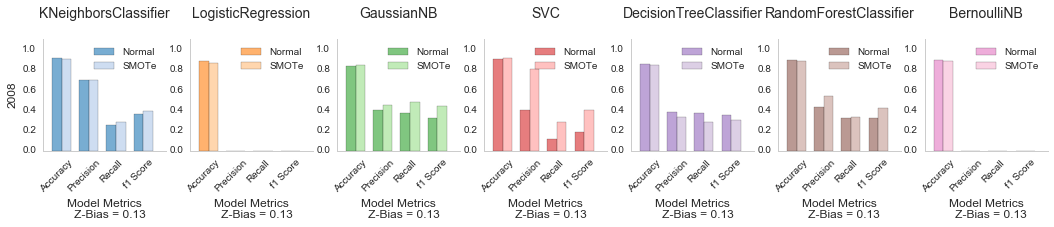

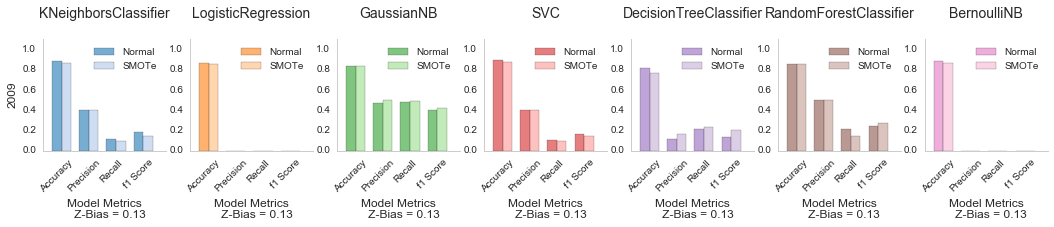

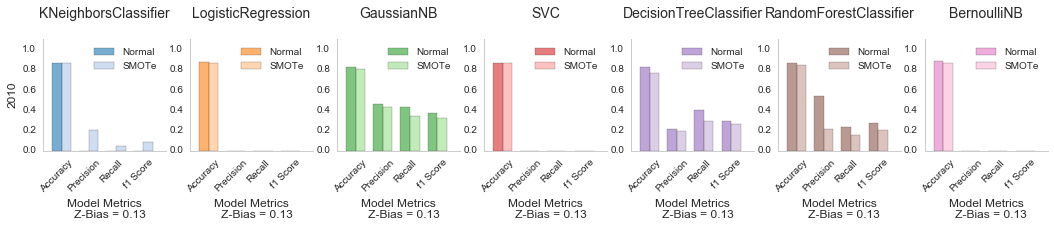

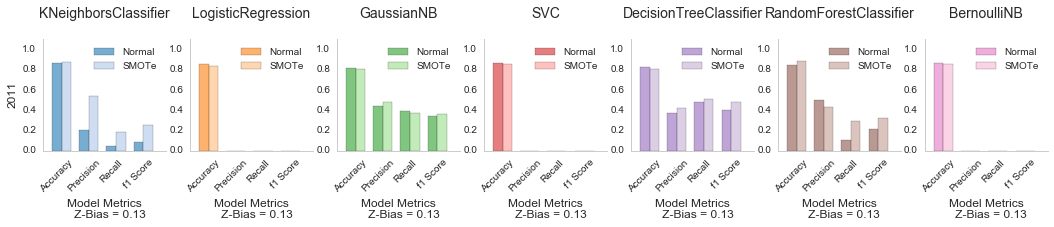

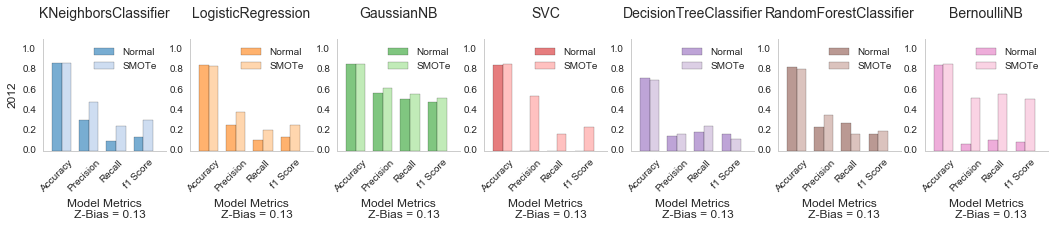

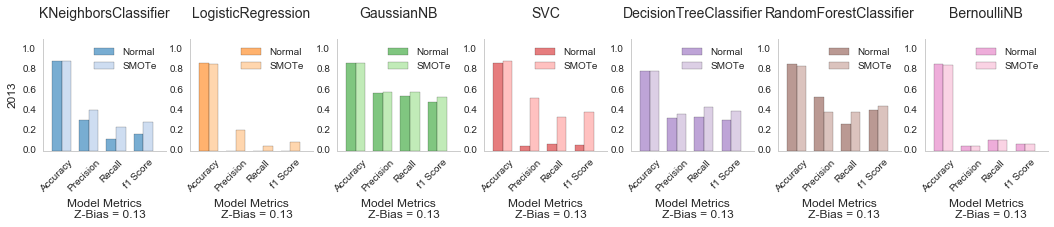

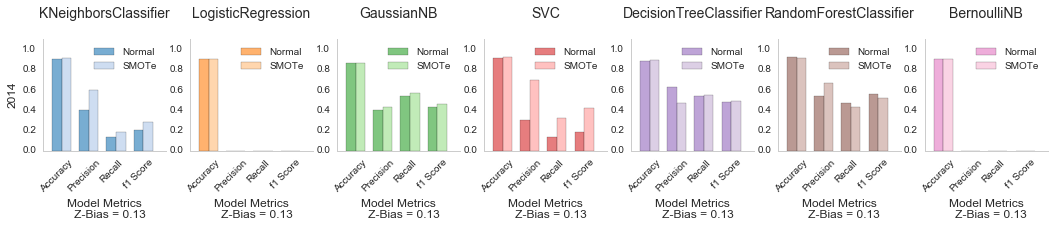

In [81]:
for i, year in enumerate(years):
        
    for j,model in enumerate(models):
        
#         printmetrics(year, i, j, model)
        plotmetrics(year, i, j, model)
#         plotrocs(year, i, j, model)
#         plotconfusion(year, i, j, model)
#         forcast('2008', 0, '2013', 5, model)
    

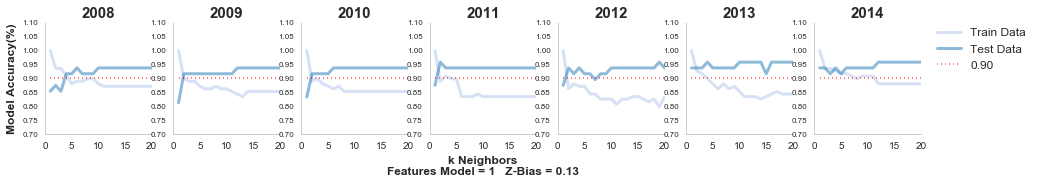

In [82]:
kNN()

kNN, Logistic Regression, SVC, and BernoulliNB all have poor Precision and Recall metrics.  The oversampled data using the SMOTe method appears to provide a little better performance in the Precision and Recall metrics (using the cross_validation method), but in Accuracy returns results only maringally higher that the normal dataset.

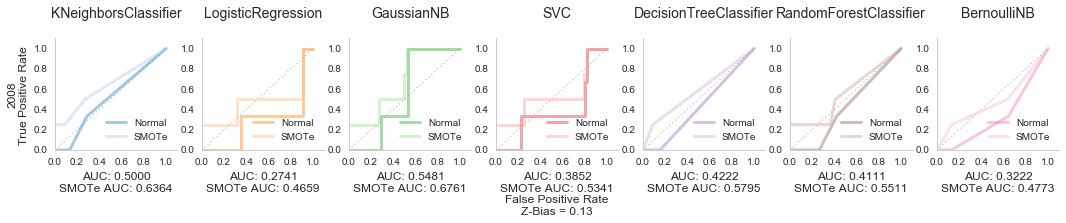

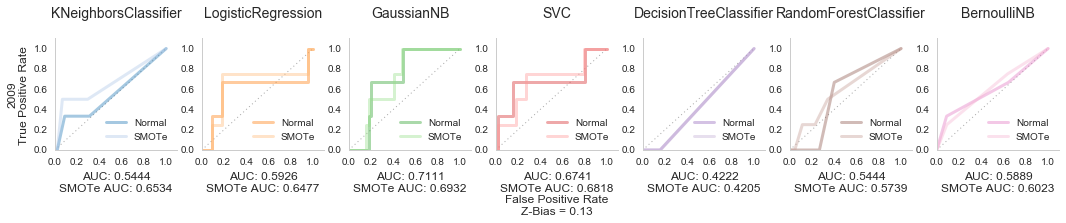

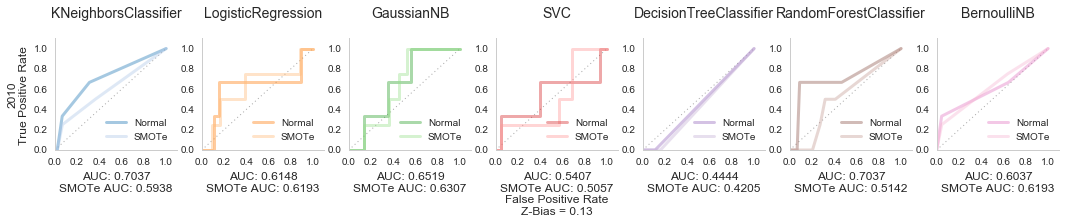

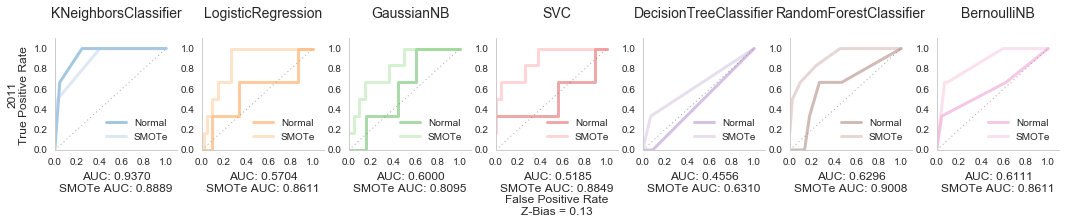

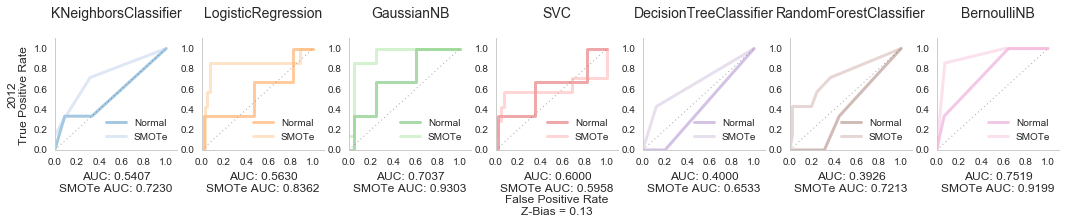

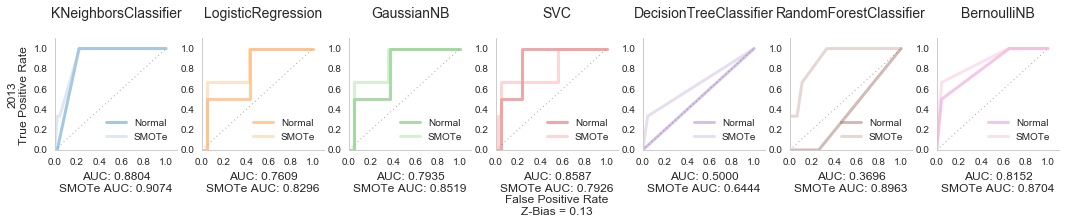

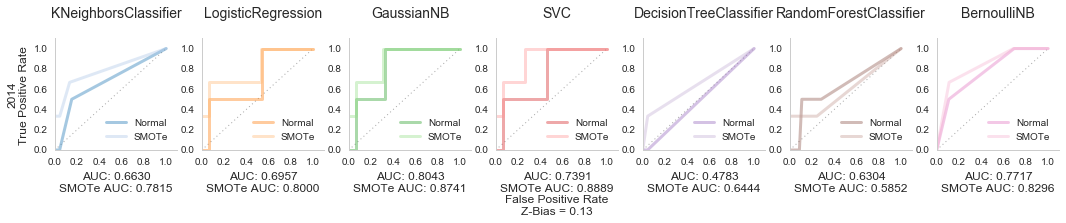

In [59]:
for i, year in enumerate(years):
        
    for j,model in enumerate(models):
        
#         printmetrics(year, i, j, model)
#         plotmetrics(year, i, j, model)
        plotrocs(year, i, j, model)
#         plotconfusion(year, i, j, model)
#         forcast('2008', 0, '2013', 5, model)
    
#     kNN()

Note the ROC curves and AUC numbers for each of the three remaining models, GaussianNB, DecisionTreeClassifier, and RandomForestClassifier in the plots above.  GaussianNB appears to have the best performance, with RandomForestClassifier second, and DecisionTreeClassifier last.

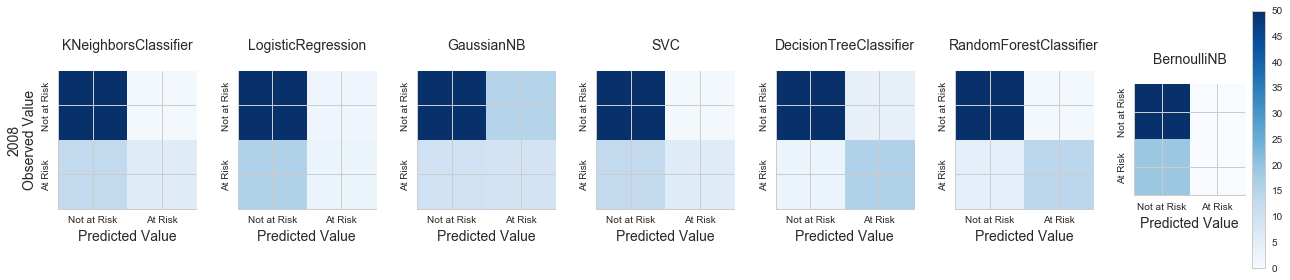

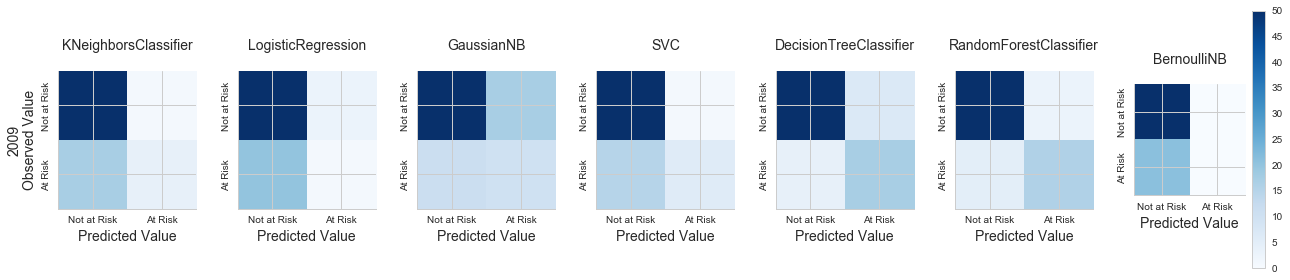

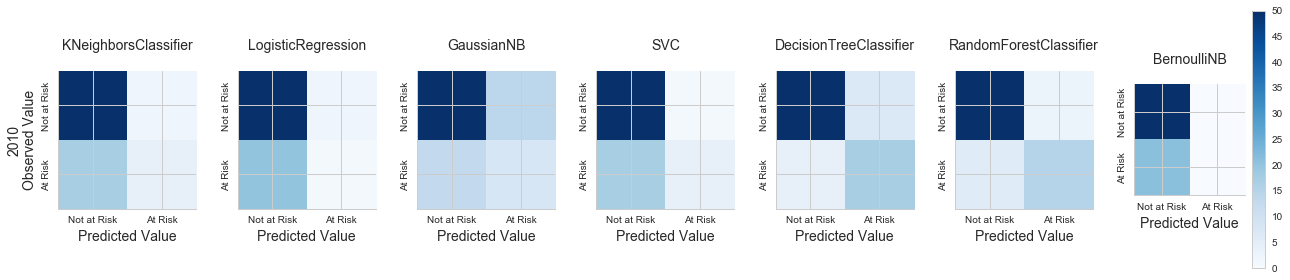

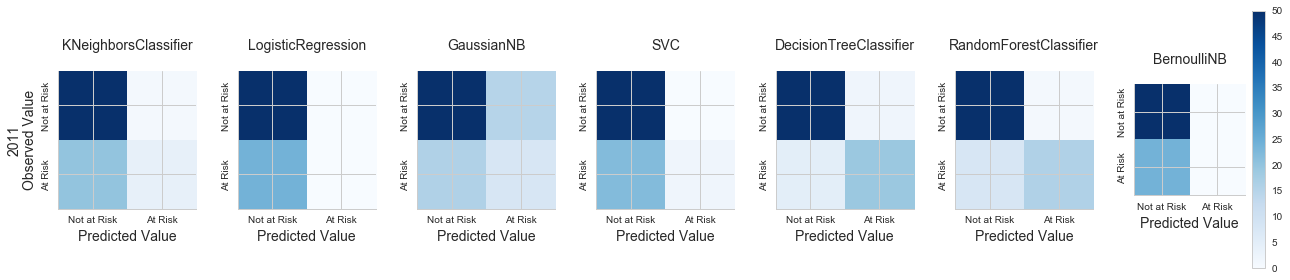

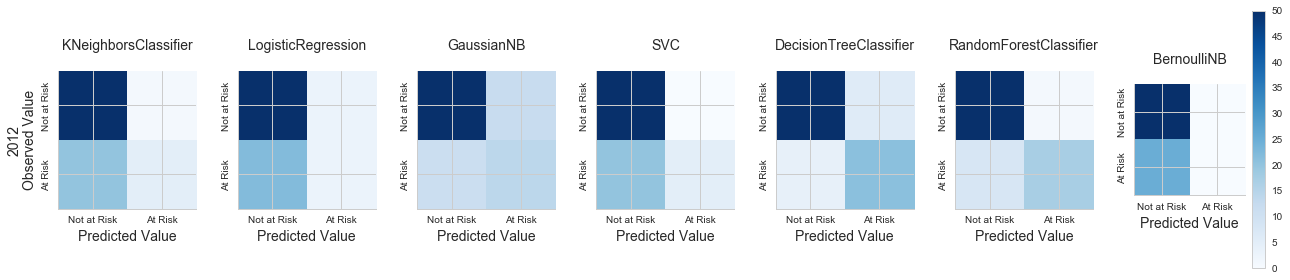

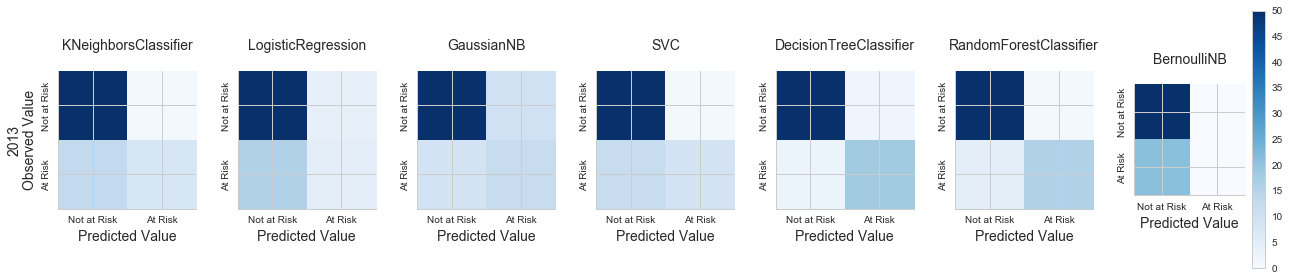

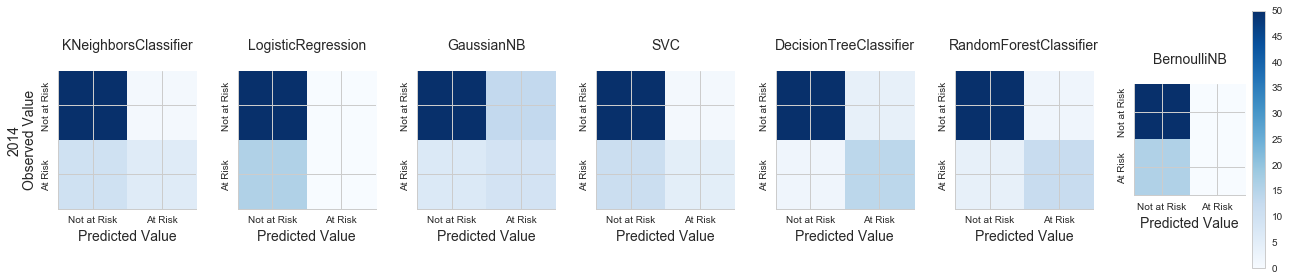

In [60]:
for i, year in enumerate(years):
    for j,model in enumerate(models):
        plotconfusion(year, i, j, model)

On further inspection, the GaussianNB model does not appear to be a good predictor for "at risk" nations, whereas both DecisionTreeClassifier and RandomForestClassifier both outperform all other models in actually predicting nations "at risk".  All confusion plots are on the same color scale.

array([[129,  13],
       [  7,   9]])

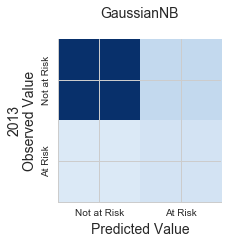

In [61]:
plotconfusion('2013', 6, 0, GaussianNB())

array([[142,   0],
       [  2,  14]])

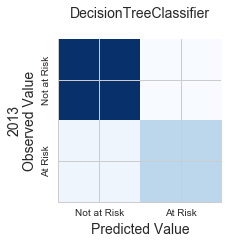

In [62]:
plotconfusion('2013', 6, 0, DecisionTreeClassifier())

array([[142,   0],
       [  3,  13]])

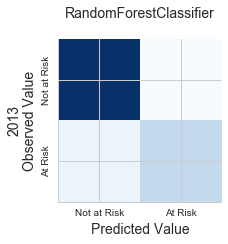

In [63]:
plotconfusion('2013', 6, 0, RandomForestClassifier())

The three confusion plots above are a repeat but include the actual numbers to quantify each model's performance.  In 2013, there were 21 observed events.  This gives an accuracy for predicting "At Risk" nations at 38%, 66%, and 57% for the GaussianNB, DecisionTree, and RandomForest models respectively.

It should be noted that the GaussianNB model did predict a number of nations "At Risk" that were not classified as "At Risk" in the observed data.  Follow-on work should look more closely that these predicted states to see if there is "a signal in the noise" that has not yet been identified.

It is counter-intuitive from looking solely at the ROC performance of the model, the DecisionTreeClassifier have a better prediction rate than RandomForest overall, and was selected for the model to use in evaluating the Security Index for this proof-of-concept study.

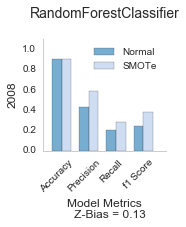

In [64]:
plotmetrics('2008', 0, 0, RandomForestClassifier())

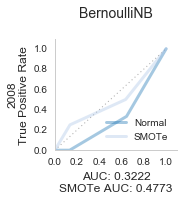

In [65]:
plotrocs('2008', 0, 0, BernoulliNB())

#### Attempt at identifying nations under duress using models trained on different year datasets.

In [66]:
modelyear = '2012'
forecastyear = '2013'
model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = GaussianNB()

a,p,r,f,result = forecast(modelyear, forecastyear, model)

Model Year:	2012
Forecast Year:	2013
Z Bias:		0.13

Cross Validation Metrics:

	Accuracy: 	0.7859
	Precision: 	0.3167
	Recall: 	0.3333
	f1 Score: 	0.3019

Predicted Nations under stress:	17
Observed Nations under stress:	19
Number of correctly predicted nations:	7

Prediction Accuracy of a 2012 DecisionTreeClassifier model
in predicting nations under stress in 2013:	0.3684

    countrycode  observed  security
1           AFG         1         1
39          COL         1         1
78          GNQ         0         1
85          HND         0         1
94          IRQ         1         1
104         KHM         0         1
111         LBN         0         1
113         LBY         0         1
139         MMR         1         1
143         MOZ         0         1
146         MWI         0         1
181         SDN         1         1
188         SOM         1         1
202         SYR         1         1
220         USA         0         1
221         UZB         0         1
230        

#### A look at the combined results from the entire team forecasting results for 2013

In [67]:
teamresults = pd.read_csv('stackedresults.csv')

teamresults.loc[teamresults['observed'] == 1]

,Unnamed: 0,countrycode,environment,political,social,economic,observed,security,count
0,0,AFG,1,1,0,0,1,1,3
10,10,BDI,1,1,0,0,1,0,2
18,18,BIH,1,1,0,0,1,0,2
24,24,BTN,1,1,0,0,1,0,2
26,26,CAF,1,0,0,0,1,0,1
35,35,COL,1,1,0,0,1,1,3
55,55,ERI,1,1,0,0,1,0,2
79,79,HRV,1,1,0,0,1,0,2
86,86,IRQ,0,1,0,0,1,1,2
109,109,LKA,1,0,0,0,1,0,1


A total of 78 nations and regions were identified as being at risk based on the outputs of all five of our models.  In those 78 nations and regions, the combined results identified 18 of the 19 countries observed at risk in 2013.  Mali was the missed country (Boko Haram).  The number boils down to 51 countries when the regions are excluded.  Counting only count those nations that had two or more ‘votes’ from our models, the number of nations identified as being at risk dropped from 51 to 19, identifying 14 of the 19 nations  observed at risk for 2013.  

**73% accuracy for a first look at the output of a stacked model.**

In [68]:
teamresults.loc[teamresults['count'] > 1]

,Unnamed: 0,countrycode,environment,political,social,economic,observed,security,count
0,0,AFG,1,1,0,0,1,1,3
10,10,BDI,1,1,0,0,1,0,2
18,18,BIH,1,1,0,0,1,0,2
24,24,BTN,1,1,0,0,1,0,2
35,35,COL,1,1,0,0,1,1,3
55,55,ERI,1,1,0,0,1,0,2
78,78,HPC,0,0,1,1,0,0,2
79,79,HRV,1,1,0,0,1,0,2
86,86,IRQ,0,1,0,0,1,1,2
103,103,LBR,1,0,0,1,0,0,2


This table shows all nations that recieved two or more votes from the stacked model.

In [69]:
teamresults.sum()

Unnamed: 0                                                 23436
countrycode    AFGAGOALBARBAREARMATGAUSAUTAZEBDIBELBENBFABGDB...
environment                                                   27
political                                                     20
social                                                        30
economic                                                       4
observed                                                      19
security                                                      20
count                                                        101
dtype: object

The table above shows the number of votes from all five models.

In [70]:
teamresults.loc[teamresults['observed'] == 1].sum()

Unnamed: 0                                                  1851
countrycode    AFGBDIBIHBTNCAFCOLERIHRVIRQLKAMLIMMRMRTRWASDNS...
environment                                                   15
political                                                     14
social                                                         0
economic                                                       0
observed                                                      19
security                                                       7
count                                                         36
dtype: object

The table above shows the number of times each of the five models correctly identified a nation at stress.

In [132]:
teamresults.loc[teamresults['count'] >= 1]

,Unnamed: 0,countrycode,environment,political,social,economic,observed,security,count
0,0,AFG,1,1,0,0,1,1,3
1,1,AGO,1,0,0,0,0,0,1
2,2,ALB,1,0,0,0,0,0,1
3,3,ARB,0,0,1,0,0,0,1
5,5,ARM,1,0,0,0,0,0,1
10,10,BDI,1,1,0,0,1,0,2
18,18,BIH,1,1,0,0,1,0,2
24,24,BTN,1,1,0,0,1,0,2
26,26,CAF,1,0,0,0,1,0,1
31,31,CHN,0,0,1,0,0,0,1


In [127]:
temp = teamresults.loc[teamresults['count'] > 1]

y = temp['observed']
X = temp['count']

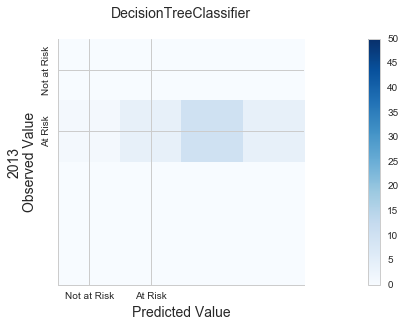

In [128]:
cm = confusion_matrix(y, X, labels=None)
year = '2013'

plt.figure(figsize=(18,4))

ax = plt.subplot(111)
sns.set_style("whitegrid")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=50)
plt.colorbar()
tick_marks = np.arange(2)
plt.tight_layout()

plt.title(str(model).split('(')[0] + '\n', fontsize = 14)
plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=0)
plt.xlabel('Predicted Value', fontsize = 14, fontweight = 'normal')
plt.yticks(tick_marks, ['Not at Risk', 'At Risk'],rotation=90)
plt.ylabel(year + '\nObserved Value', fontsize = 14, fontweight = 'normal')
#     else:
#         plt.ylabel('Observed Value')

# Creates file for coloring d3 globe.

### Create a mapcolor file using the binary outputs of each node (Political, Economic, Social, Environmental, Security)

In [71]:
others = pd.read_csv('Others.csv')
bryan = pd.read_csv('bryan_2013_prediction.csv')

In [72]:
result.head(3)

,countrycode,observed,security
1,AFG,1,1
2,AGO,0,0
3,ALB,0,0


In [73]:
new = others.merge(bryan[['countrycode', 'economic']], on = 'countrycode', how = 'outer')
new = new.merge(result[['countrycode', 'observed', 'security']], on = 'countrycode', how = 'outer')

new = new.fillna({'environment': 0})
new = new.fillna({'political': 0})
new = new.fillna({'social': 0})
new = new.fillna({'economic': 0})
new = new.fillna({'observed': 0})
new = new.fillna({'security': 0})

#### Creates a sum or binary color value for the d3 Globe map based on predicted outputs from all models

In [74]:
# mapcolor = 'binary'
mapcolor = 'gradient'

## For binary mapcolors, set the mapcolorbias value to determine the threshold level.
mapcolorbias = 2

if mapcolor == 'gradient':
    new['count'] = new['environment'] + new['political'] + new['social'] + new['economic'] + new['security']
else:
    new['bin'] = np.where(new['count'] >= mapcolorbias, 1, 0)

In [75]:
new.head(3)

new.to_csv('stackedresults.csv')

In [76]:
web = pd.read_csv('moved.tsv', '\t')

web.head(3)

,id,colortest,countrycode,name
0,4,3,AFG,Afghanistan
1,8,1,ALB,Albania
2,10,0,ATA,Antarctica


In [77]:
newweb = web.merge(new[['countrycode', 'count']], on = 'countrycode', how = 'outer')
newweb = newweb.fillna({'count': 0})
newweb = newweb.dropna()

stacked = pd.concat([newweb['id'], newweb['count'], newweb[['countrycode', 'name']] ], axis=1)
stacked.columns = ['id', 'colortest', 'countrycode', 'name']

stacked['id'] = stacked['id'].astype(int)
stacked['colortest'] = stacked['colortest'].astype(int)

stacked.to_csv('newmoved.tsv', sep = '\t', index = False)

stacked.loc[stacked['colortest'] == 3]

,id,colortest,countrycode,name
0,4,3,AFG,Afghanistan
47,170,3,COL,Colombia
205,706,3,SOM,Somalia
210,729,3,SDN,Sudan


In [78]:
stacked.dtypes

id              int64
colortest       int64
countrycode    object
name           object
dtype: object